In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
import numpy as np 
import os
import glob
import numpy as np 
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from PIL import Image



In [3]:

def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = LeakyReLU() , padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = LeakyReLU() , padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = LeakyReLU() , padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = LeakyReLU() , padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = LeakyReLU() , padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = LeakyReLU() , padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = LeakyReLU() , padding = 'same')(pool3)
    conv4 = Conv2D(512, 3, activation = LeakyReLU() , padding = 'same')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = LeakyReLU() , padding = 'same')(pool4)
    conv5 = Conv2D(1024, 3, activation = LeakyReLU() , padding = 'same')(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(512, 2, activation = LeakyReLU() , padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = LeakyReLU() , padding = 'same')(merge6)
    conv6 = Conv2D(512, 3, activation = LeakyReLU() , padding = 'same')(conv6)

    up7 = Conv2D(256, 2, activation = LeakyReLU() , padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = LeakyReLU() , padding = 'same')(merge7)
    conv7 = Conv2D(256, 3, activation = LeakyReLU() , padding = 'same')(conv7)

    up8 = Conv2D(128, 2, activation = LeakyReLU() , padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = LeakyReLU() , padding = 'same')(merge8)
    conv8 = Conv2D(128, 3, activation = LeakyReLU() , padding = 'same')(conv8)

    up9 = Conv2D(64, 2, activation = LeakyReLU() , padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = LeakyReLU() , padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = LeakyReLU() , padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = LeakyReLU() , padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)
  
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()



    return model

In [ ]:
#def adjustData(img,mask):
#  img = img / 255
#  mask = mask /255
#  mask[mask > 0.5] = 1
#  mask[mask <= 0.5] = 0
#  return (img,mask)


def adjustData(img,mask):
  img = img / 255
  #min = img.min()
  #max = img.max()
  #img_normalized = 2.0 * (img - min) / (max - min) - 1.0
  mask = mask /255
  mask[mask > 0.5] = 1
  mask[mask <= 0.5] = 0
  return (img,mask)

def testGenerator(test_path,instance = None):
  path =test_path + instance
  path1 = os.listdir(path)
  path1.sort()
  for filename in path1:
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      #img = np.reshape(img,img.shape+(1,))
      img = np.reshape(img,(1,)+img.shape)
      yield img


def my_image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img, mask)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

path = '/content/drive/MyDrive/dataset/train/'

#############################################################
#############################################################
validation_split=0.2
batch_size = 8
seed = 7
epochs = 100
#############################################################
#############################################################


# ------------- TRAINING DATA GENERATOR ---------------------------------------#
data_gen_args_for_training = dict(rotation_range=0.2, width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05,
                   zoom_range=0.05,horizontal_flip=True,fill_mode='nearest',validation_split = validation_split )

#data_gen_args_for_training = dict(validation_split = validation_split )                  
validation_args = dict(validation_split = validation_split)

#data_gen_args_for_training = dict(validation_split = validation_split )
train_image_datagen = ImageDataGenerator(**data_gen_args_for_training)
mask_image_datagen = ImageDataGenerator(**data_gen_args_for_training)

train_image_generator = train_image_datagen.flow_from_directory(
        directory=path,
        subset="training",
        classes = ['AFTER'],
        class_mode = None,
        color_mode = "rgb",
        target_size = (256,256),
        batch_size = batch_size,
        save_to_dir = None,
        seed = seed)

mask_generator = mask_image_datagen.flow_from_directory(
        directory=path,
        subset="training",
        classes = ['MASK'],
        class_mode = None,
        color_mode = "grayscale",
        target_size = (256,256),
        batch_size = batch_size,
        save_to_dir = None,
        seed = seed)



    
STEP_SIZE_TRAIN = train_image_generator.n // batch_size

# ------------------ VALIDATION DATA GENERATOR -------------------------------#


validation_image_datagen = ImageDataGenerator(**validation_args)

validation_image_generator = validation_image_datagen.flow_from_directory(
        directory=path,
        subset="validation",
        classes = ['AFTER'],
        class_mode = None,
        color_mode = "rgb",
        target_size = (256,256),
        batch_size = batch_size,
        save_to_dir = None,
        seed = seed)

validation_mask_image_datagen = ImageDataGenerator(**validation_args)


validationmask_generator = validation_mask_image_datagen.flow_from_directory(
        directory=path,
        subset="validation",
        classes = ['MASK'],
        class_mode = None,
        color_mode = "grayscale",
        target_size = (256,256),
        batch_size = batch_size,
        save_to_dir = None,
        seed = seed)


STEP_SIZE_VAL = validation_image_generator.n // batch_size

training_generator = my_image_mask_generator(train_image_generator, mask_generator)


validation_generator = my_image_mask_generator(validation_image_generator, validationmask_generator)

model= unet()

model.fit_generator(
    training_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_data = validation_generator, 
    validation_steps = STEP_SIZE_VAL,epochs = epochs)

#myGene = trainGenerator(8,path,'image','label',data_gen_args,save_to_dir =None)
#save_to_dir ='/content/drive/MyDrive/flood_mapping/data/membrane/train/aug'
#model = unet()
#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
#floodNET = model.fit(myGene,steps_per_epoch=150,epochs=25)

#model.save('/content/drive/MyDrive/flood_mapping/floodmodel.h5')


Found 720 images belonging to 1 classes.
Found 720 images belonging to 1 classes.
Found 180 images belonging to 1 classes.
Found 180 images belonging to 1 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D) 

In [4]:
model = unet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.history.history

{'accuracy': [0.6401048302650452,
  0.662480354309082,
  0.6675187945365906,
  0.6687196493148804,
  0.6764733195304871,
  0.6755290627479553,
  0.6740409135818481,
  0.6746420860290527,
  0.6813461184501648,
  0.6786174774169922,
  0.6784753799438477,
  0.6839233636856079,
  0.68523108959198,
  0.6815723180770874,
  0.6875931024551392,
  0.687830924987793,
  0.6905888915061951,
  0.6894659996032715,
  0.6906696557998657,
  0.700776219367981,
  0.7048524022102356,
  0.7122933268547058,
  0.7102422118186951,
  0.7248913049697876,
  0.7297553420066833,
  0.7429500222206116,
  0.7360318303108215,
  0.7455434203147888,
  0.7506393194198608,
  0.7514656186103821,
  0.7518361210823059,
  0.7515755295753479,
  0.7531214952468872,
  0.7498219609260559,
  0.7569029927253723,
  0.7579991817474365,
  0.7641818523406982,
  0.7689055800437927,
  0.7670619487762451,
  0.7648271322250366,
  0.7700105309486389,
  0.7773116230964661,
  0.7752386927604675,
  0.7817360758781433,
  0.7801003456115723,
  0

In [ ]:
model.save("/content/drive/MyDrive/flood_mapping/models/b8e100UNET.h5")
import pickle
with open('/content/drive/MyDrive/flood_mapping/models/b8e100UNETHistoryDict', 'wb') as file_pi:
        pickle.dump(model.history.history, file_pi)

In [ ]:
#floodNET = load_model('/content/drive/MyDrive/flood_mapping/floodmodel.h5',compile = True)

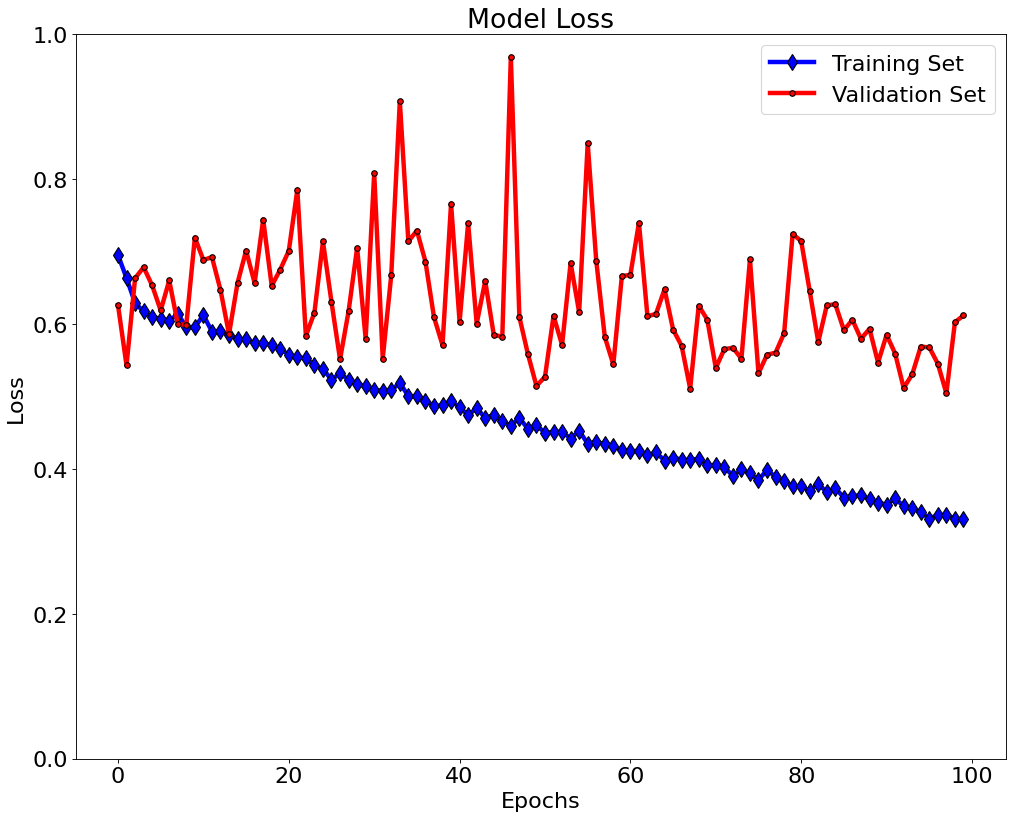

In [ ]:

fig, ax = plt.subplots(figsize=(15,12),dpi=80)
ax.plot(np.array(model.history.history['loss']),'b-',marker="d",markersize=10, markeredgecolor='k',label='Training Set',linewidth=4)
ax.plot(np.array(model.history.history['val_loss']),'r-',linestyle='-',marker=".",markersize=10,markeredgecolor='k',label='Validation Set',linewidth=4)
ax.set_title('Model Loss',fontsize=24)
ax.set_ylabel('Loss ',fontsize=50)
ax.set_xlabel('Epochs',fontsize=50)
ax.legend(loc='upper right',fontsize=20)
ax.set_ylim(ymin=0,ymax=1)
for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.show()




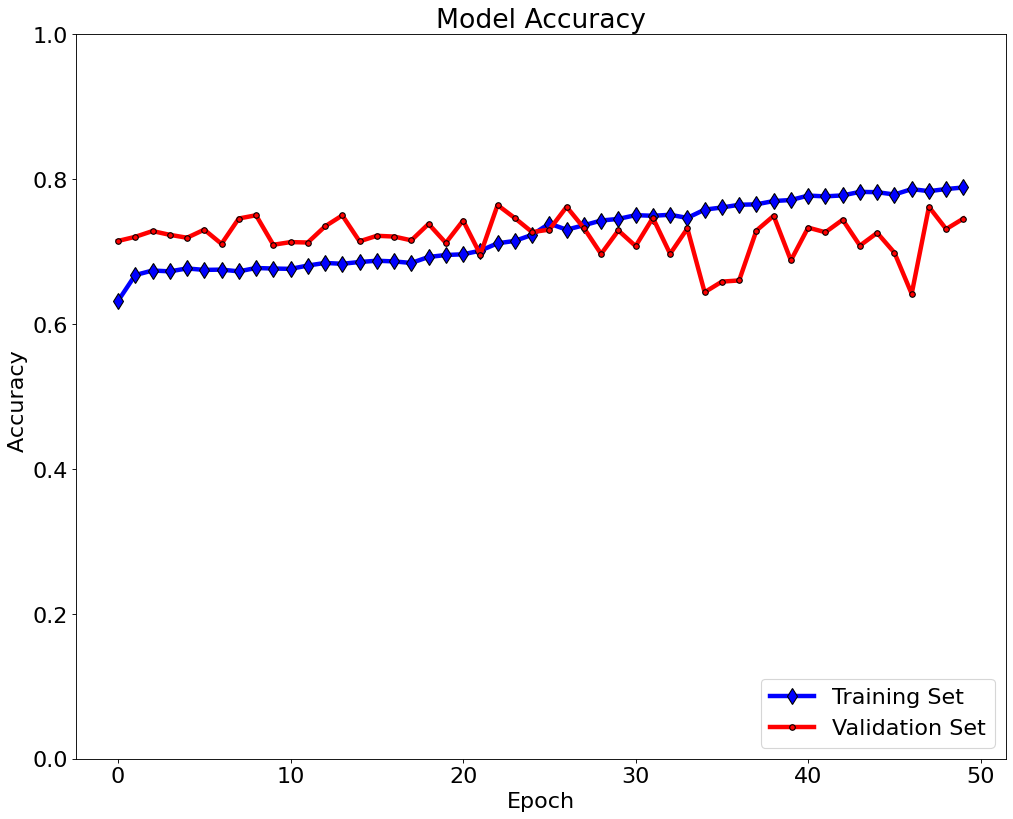

In [ ]:
fig, ax = plt.subplots(figsize=(15,12),dpi=80)
ax.plot(np.array(model.history.history['accuracy']),'b-',marker="d",markersize=10, markeredgecolor='k',label='Training Set',linewidth=4)
ax.plot(np.array(model.history.history['val_accuracy']),'r-',linestyle='-',marker=".",markersize=10,markeredgecolor='k',label='Validation Set',linewidth=4)
ax.set_title('Model Accuracy',fontsize=24)
ax.set_ylabel('Accuracy ',fontsize=50)
ax.set_xlabel('Epoch',fontsize=50)
ax.legend(loc='lower right',fontsize=20)
ax.set_ylim(ymin=0,ymax=1)
for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.show()




{}

In [ ]:
test_path = '/content/drive/MyDrive/dataset/test/'
instance = 'AFTER'
testGene = testGenerator(test_path,instance)
results = model.predict(testGene,verbose=1)


100/100 [==============================] - 1s 10ms/step


In [ ]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


def IoU(y_true,y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    union = keras.sum(y_true_f) + keras.sum(y_pred_f) - intersection
    return intersection/union
     
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)
  
def bce_dice_loss(y_true, y_predict):
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

def  dice_loss(y_true, y_predict):
    return (1-dice_coef(y_true, y_predict))

"""
_dice.py : Dice coefficient for comparing set similarity.
"""



def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [ ]:
y_true = []
x_true = [] 

maskFolder = "MASK"
path = os.path.join(test_path ,maskFolder)
path1 = os.listdir(path)
path1.sort()
for filename in path1 :
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      y_true.append(img)


imgFolder = "AFTER"
path = os.path.join(test_path ,imgFolder)
path2 = os.listdir(path)
path2.sort()
for filename in path2:
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      x_true.append(img)




In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/flood_mapping')
import metrics_v2 
import miou


y_pred =np.where(results[:,:,:,0]>.5,1,0)
#pred = np.where(pred > 0.5, 1, 0)

dice_loss = []
pix_acc = []
mean_acc =[]
mean_IoU = []
FW_IoU =[]

for i in range(0,len(y_true)):

  pix_acc.append(pixel_accuracy(y_pred[i], y_true[i]))
  mean_acc.append(mean_accuracy(y_pred[i], y_true[i]))
  mean_IoU.append(mean_IU(y_pred[i], y_true[i]))
  FW_IoU.append(frequency_weighted_IU(y_pred[i], y_true[i]))

print( pix_acc)
print( mean_acc)
print(mean_IoU) 
print(FW_IoU) 

average_pix_acc = sum(pix_acc) / len(pix_acc)
average_mean_acc =(sum( mean_acc)/len( mean_acc))
average_IoU = (sum( mean_IoU)/len( mean_IoU))
average_FW_IoU = (sum( FW_IoU)/len( FW_IoU))

print('Average Pixel Accuracy : ' + str(round(average_pix_acc, 4)) )
print('Mean Accuracy : ' + str(round(average_mean_acc , 4)) )
print('Mean IoU : ' + str(round(average_IoU , 4)) )   
print('FW IoU : ' + str(round(average_FW_IoU  , 4))  )

[0.9274139404296875, 0.7463226318359375, 0.950439453125, 0.7017059326171875, 0.6474151611328125, 0.8892822265625, 0.7859344482421875, 0.659820556640625, 0.80364990234375, 0.6518402099609375, 0.788421630859375, 0.5245513916015625, 0.95635986328125, 0.756683349609375, 0.7321319580078125, 0.6219635009765625, 0.84375, 0.5294189453125, 0.64862060546875, 0.477264404296875, 0.4934844970703125, 0.8600921630859375, 0.9640045166015625, 0.9521636962890625, 0.9717254638671875, 0.49578857421875, 0.9063568115234375, 0.924652099609375, 0.9277496337890625, 0.9766845703125, 0.92376708984375, 0.7399749755859375, 0.327392578125, 0.74359130859375, 0.8872222900390625, 0.68035888671875, 0.7865142822265625, 0.8993988037109375, 0.9290313720703125, 0.94476318359375, 0.9335479736328125, 0.9037322998046875, 0.968353271484375, 0.50396728515625, 0.7518463134765625, 0.6988677978515625, 0.9214630126953125, 0.363555908203125, 0.963134765625, 0.9569549560546875, 0.951141357421875, 0.8599395751953125, 0.817153930664062

Text(0.5, 1.0, 'Binary Prediction')

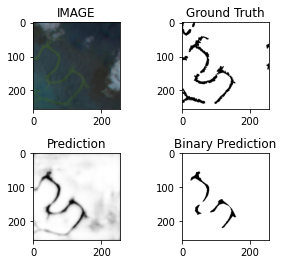

In [ ]:
index =50
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(x_true[index])
ax.set_title('IMAGE')
ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(y_true[index],cmap=plt.cm.gray)
ax.set_title('Ground Truth')
ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(np.array(results[index,:,:]).reshape((256,256)),cmap=plt.cm.gray)
ax.set_title('Prediction')
ax = fig.add_subplot(2, 2, 4)

plt.subplots_adjust(wspace=-0.2, hspace=0.5)
imgplot = plt.imshow(y_pred[index],cmap=plt.cm.gray)
ax.set_title('Binary Prediction')

In [ ]:
# i = 1    // 0007
# i = 23   // 0273
# i = 50  //  0534
im = Image.fromarray((y_pred[index]*255).astype(np.uint8))
im.save("/content/drive/MyDrive/flood_mapping/plots/prediction_0534.png")